Kaggle Dataset of BRaTs2020

https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/data


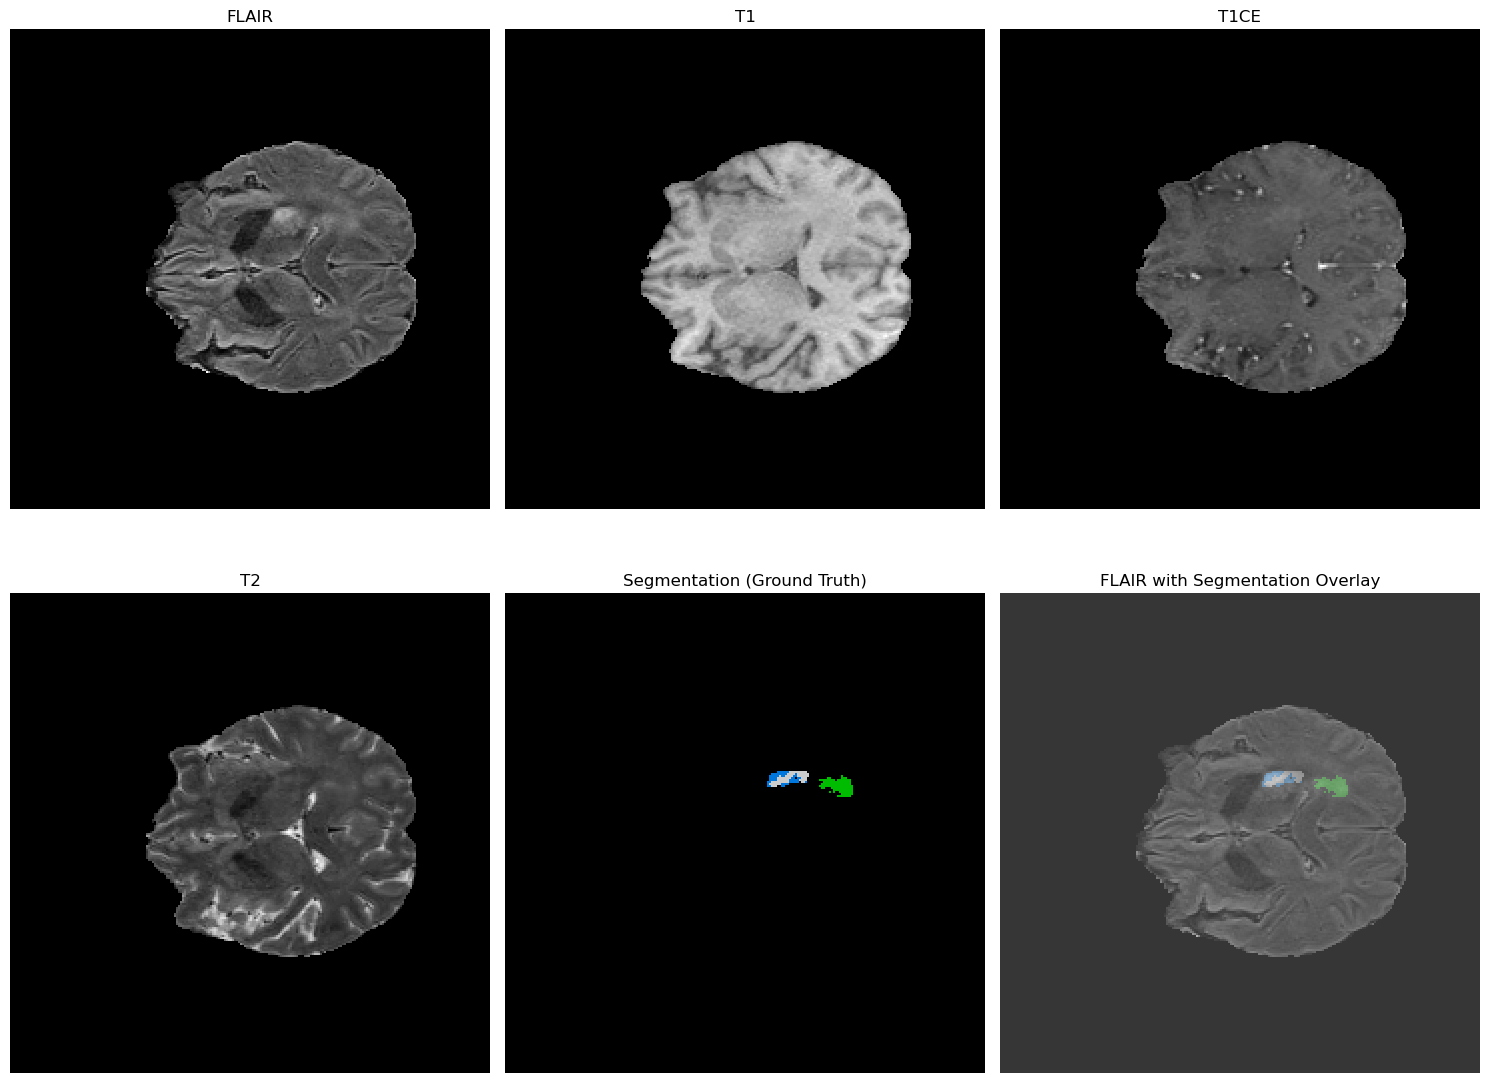

In [8]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the BraTS2020 dataset directory
dataset_path = "/Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData" # Change to your downloaded file unzipped (too large for Git)

# Function to load a NIfTI file
def load_nifti(file_path):
    """Load a NIfTI file and return the data as a NumPy array."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

# List all patient folders in the dataset
cases = [case for case in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case))]

# Example: Load and visualize data for one case
example_case = cases[2]  # Select the first case, e.g., BraTS20_Training_369
case_path = os.path.join(dataset_path, example_case)

# Define the actual file paths based on patient folder structure
modalities = ["flair", "t1", "t1ce", "t2"]
modality_files = {modality: os.path.join(case_path, f"{example_case}_{modality}.nii") for modality in modalities}
segmentation_file = os.path.join(case_path, f"{example_case}_seg.nii")

# Check if all files exist
for file_path in list(modality_files.values()) + [segmentation_file]:
    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

# Load the NIfTI files for modalities and segmentation
loaded_modalities = {modality: load_nifti(file) for modality, file in modality_files.items()}
segmentation = load_nifti(segmentation_file)

# Visualize an example slice
slice_idx = 75  # You can modify this index to explore different slices

plt.figure(figsize=(15, 12))

# Plot the modalities
for i, (modality, data) in enumerate(loaded_modalities.items()):
    plt.subplot(2, 3, i + 1)
    plt.imshow(data[:, :, slice_idx], cmap="gray")
    plt.title(modality.upper())
    plt.axis("off")

# Plot the segmentation mask
plt.subplot(2, 3, 5)
plt.imshow(segmentation[:, :, slice_idx], cmap="nipy_spectral")
plt.title("Segmentation (Ground Truth)")
plt.axis("off")

# Overlay segmentation mask on one modality (e.g., FLAIR)
plt.subplot(2, 3, 6)
plt.imshow(loaded_modalities["flair"][:, :, slice_idx], cmap="gray", alpha=0.7)
plt.imshow(segmentation[:, :, slice_idx], cmap="nipy_spectral", alpha=0.3)
plt.title("FLAIR with Segmentation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


Model Creation

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Attention block
def attention_block(x, g, inter_channels):
    """Attention mechanism for encoder-decoder architecture."""
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi_f = layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='sigmoid')(f)
    return layers.multiply([x, psi_f])

# Encoder-decoder with depthwise separable convolutions
def attention_unet(input_shape=(240, 240, 4), num_classes=5):
    """Custom U-Net with depthwise separable convolutions and attention."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, attention_block(c3, u5, 128)])
    c5 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, attention_block(c2, u6, 64)])
    c6 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, attention_block(c1, u7, 32)])
    c7 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    return Model(inputs, outputs)

# Instantiate the model
model = attention_unet()


In [10]:
def dice_loss(y_true, y_pred):
    """Calculate Dice loss."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Calculate Focal loss."""
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    loss = -y_true * alpha * (1 - y_pred)**gamma * tf.math.log(y_pred)
    return tf.keras.backend.mean(tf.keras.backend.sum(loss, axis=-1))

def hybrid_loss(y_true, y_pred):
    """Combine Dice loss and Focal loss."""
    return dice_loss(y_true, y_pred) + focal_loss(y_true, y_pred)


In [11]:
# Normalize and resize data
def preprocess(images, masks, target_shape=(240, 240)):
    """Normalize, resize, and augment images and masks."""
    images = tf.image.resize(images, target_shape)
    masks = tf.image.resize(masks, target_shape, method='nearest')
    images = images / tf.reduce_max(images)  # Normalize to [0, 1]
    return images, masks

# Data augmentation
@tf.function
def augment(images, masks):
    """Apply random augmentation."""
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return images, masks


In [15]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ============================================
# Dataset Preprocessing Functions
# ============================================
def load_nifti(file_path):
    """Load a NIfTI file and return the data as a NumPy array."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

def preprocess_data(case_path, target_shape=(240, 240)):
    """
    Load modalities and segmentation, normalize them, 
    resize, and return individual 2D slices.
    """
    modalities = ["flair", "t1", "t1ce", "t2"]
    modality_files = {modality: os.path.join(case_path, f"{case_path.split('/')[-1]}_{modality}.nii") for modality in modalities}
    segmentation_file = os.path.join(case_path, f"{case_path.split('/')[-1]}_seg.nii")

    # Load modalities and segmentation
    images = np.stack([load_nifti(modality_files[modality]) for modality in modalities], axis=-1)
    mask = load_nifti(segmentation_file)
    
    # Normalize images
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    
    # Resize and return as individual slices
    images_resized = []
    masks_resized = []
    for slice_idx in range(images.shape[2]):  # Iterate over slices
        slice_img = tf.image.resize(images[:, :, slice_idx, :], target_shape).numpy()
        slice_mask = tf.image.resize(mask[:, :, slice_idx][..., np.newaxis], target_shape, method='nearest').numpy()
        images_resized.append(slice_img)
        masks_resized.append(slice_mask)
    return np.array(images_resized), np.array(masks_resized)

# ============================================
# Load and Split Dataset
# ============================================
def prepare_dataset(dataset_path, target_shape=(240, 240), test_size=0.2, val_size=0.1):
    """Prepare train, validation, and test datasets."""
    # List all patient cases
    case_folders = [os.path.join(dataset_path, case) for case in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, case))]

    X, Y = [], []
    for case_path in case_folders:
        print(f"Processing {case_path}...")
        images, masks = preprocess_data(case_path, target_shape)
        X.extend(images)
        Y.extend(masks)
    X = np.array(X)
    Y = np.array(Y)

    # Train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

    # Train-validation split
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, random_state=42)

    print(f"Dataset prepared: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# ============================================
# TensorFlow Dataset Creation
# ============================================
def tf_dataset(X, Y, batch_size=16, augment=False):
    """Create a TensorFlow dataset."""
    def preprocess(image, mask):
        """Normalize images and one-hot encode masks."""
        image = tf.cast(image, tf.float32)
        mask = tf.cast(mask, tf.int32)
        mask = tf.one_hot(mask[..., 0], depth=5)  # One-hot encoding for 5 classes (0, 1, 2, 4)
        return image, mask

    def augment_data(image, mask):
        """Apply data augmentation."""
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# ============================================
# Main Script
# ============================================
# Define dataset path and parameters
dataset_path = "/Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"  # Update this path
target_shape = (240, 240)  # Resize images to this shape
batch_size = 16

# Prepare datasets
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(dataset_path, target_shape=target_shape)

# Create TensorFlow datasets
train_dataset = tf_dataset(X_train, Y_train, batch_size=batch_size, augment=True)
val_dataset = tf_dataset(X_val, Y_val, batch_size=batch_size, augment=False)
test_dataset = tf_dataset(X_test, Y_test, batch_size=batch_size, augment=False)

print("Datasets created successfully!")


Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_082...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_244...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_076...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_049...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_071...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_243...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_085...
Processing /Users/benbaize/Downloads/archive-3/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_288...
Processi

: 

In [1]:
# Prepare datasets
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Convert data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

# Apply preprocessing and augmentation
train_dataset = (
    train_dataset
    .map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: augment(x, y), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
val_dataset = (
    val_dataset
    .map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Compile model with hybrid loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=hybrid_loss,
              metrics=['accuracy', dice_loss])

# Train model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_steps=len(X_val) // BATCH_SIZE)


NameError: name 'tf' is not defined

In [ ]:
# Predict on validation data
sample_idx = 0
predictions = model.predict(X_val[sample_idx:sample_idx+1])
predicted_mask = tf.argmax(predictions[0], axis=-1)

# Visualize the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_val[sample_idx][:, :, 0], cmap='gray')  # First modality
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(tf.argmax(Y_val[sample_idx], axis=-1), cmap='nipy_spectral')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='nipy_spectral')
plt.title("Predicted Mask")
plt.show()
